Dataset is taken from kaggle: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

#Downloading necessary libraries

In [ ]:
!pip install tensorflow scikit-learn
!pip install numpy matplotlib opencv-python-headless

#Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


#Loading and Preprocessing the Dataset

In [ ]:

train_data_dir = "/content/drive/MyDrive/codeclause-internship/dataset/data/"
train_mask_dir = "with_mask"
train_no_mask_dir = "without_mask"


In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

#Building the Model

In [ ]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    classes=[train_mask_dir, train_no_mask_dir]
)

Found 7553 images belonging to 2 classes.


# Load MobileNetV2 base model without the top (fully connected) layers

In [ ]:

base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the top layers of the model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(1, activation="sigmoid")(head_model)

# Combine the base and top layers to create the final model
model = Model(inputs=base_model.input, outputs=head_model)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


# Load MobileNetV2 base model without the top (fully connected) layers

In [ ]:

base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the top layers of the model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(1, activation="sigmoid")(head_model)

# Combine the base and top layers to create the final model
model = Model(inputs=base_model.input, outputs=head_model)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

#Compiling and Training the Model

In [ ]:
# Compile the model
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=train_generator.samples // train_generator.batch_size * 20, decay_rate=0.9
)
opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5
)


Epoch 1/5
145/236 [=================>............] - ETA: 6:36 - loss: 0.2953 - accuracy: 0.8768

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


236/236 [==============================] - 1083s 4s/step - loss: 0.2310 - accuracy: 0.9076
Epoch 2/5
236/236 [==============================] - 253s 1s/step - loss: 0.0871 - accuracy: 0.9703
Epoch 3/5
236/236 [==============================] - 246s 1s/step - loss: 0.0684 - accuracy: 0.9769
Epoch 4/5
236/236 [==============================] - 249s 1s/step - loss: 0.0580 - accuracy: 0.9785
Epoch 5/5
236/236 [==============================] - 247s 1s/step - loss: 0.0533 - accuracy: 0.9821


# Evaluate the model

In [ ]:

print("[INFO] Evaluating the network...")
predictions = model.predict(train_generator)
predictions = (predictions > 0.5).astype(int)
print(classification_report(train_generator.classes, predictions))


[INFO] Evaluating the network...
237/237 [==============================] - 254s 1s/step
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      3725
           1       0.50      0.50      0.50      3828

    accuracy                           0.50      7553
   macro avg       0.50      0.50      0.50      7553
weighted avg       0.50      0.50      0.50      7553



# Save the model

In [ ]:
model.save("/content/mask_detection_model.h5")

#USING OUR TRAINED MODEL FOR MASK DETECTION WITH HARR CASCADE FOR FACE DETECTION TO DETECT MASKS IN IMAGES AND DRAW BOUNDING BOX

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import cv2

def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    return image


In [ ]:
# Load the saved models
face_detection_model = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")
mask_detection_model = tf.keras.models.load_model("/content/mask_detection_model.h5")

# Load and preprocess a test image
test_image_path = "/content/latin-man-mockup-psd-wearing-face-mask-new-normal_53876-143275.jpg"
image = cv2.imread(test_image_path)

1/1 [==============================] - 1s 1s/step


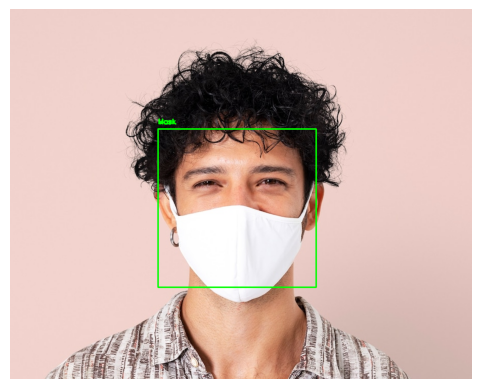

In [3]:

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_detection_model.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

for (x, y, w, h) in faces:
    face_roi = image[y:y+h, x:x+w]
    face_roi = cv2.resize(face_roi, (224, 224))
    face_roi = preprocess_input(face_roi)
    face_roi = np.expand_dims(face_roi, axis=0)

    predictions = mask_detection_model.predict(face_roi)
    mask_probability = predictions[0][0]

    if mask_probability > 0.5:
        label = "No Mask"

        color = (0, 0, 255)
    else:
        label = "Mask"
        color = (0, 255, 0)
    cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
